In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF

In [3]:
preprocess = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225]),
                            transforms.Lambda(lambda t: t.unsqueeze(0))
                            ])

In [4]:
image = Image.open('../test/cat.jpg')
img = preprocess(image)

In [5]:
cnn = torchvision.models.googlenet(pretrained=True)
cnn.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [6]:
class Hook:
    
    def __init__(self, name, layer, backward=False):
        
        self.name = name
        
        if backward:
            #print('backward pass')
            layer.register_backward_hook(self.hook_fn)
        else:
            layer.register_forward_hook(self.hook_fn)
            
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
        self.module = module
        print(f'{self.name} output shape : {output.shape}')

In [7]:
hooks = []
def recursive_hook(module, hooks, depth):
    for name, layer in module.named_children():
        #print('\t'*depth,f'Going in {name}')
        print('\t'*depth,name)
        #if isinstance(layer, nn.Conv2d):
        if name == 'inception5b':
            hooks.append(Hook(name, layer))
            #hooks.append(Hook(layer, True))
            print('\t'*depth, f'{name} layer hooked')
        recursive_hook(layer, hooks, depth+1)

In [8]:
recursive_hook(cnn, hooks, 0)

 conv1
	 conv
	 bn
 maxpool1
 conv2
	 conv
	 bn
 conv3
	 conv
	 bn
 maxpool2
 inception3a
	 branch1
		 conv
		 bn
	 branch2
		 0
			 conv
			 bn
		 1
			 conv
			 bn
	 branch3
		 0
			 conv
			 bn
		 1
			 conv
			 bn
	 branch4
		 0
		 1
			 conv
			 bn
 inception3b
	 branch1
		 conv
		 bn
	 branch2
		 0
			 conv
			 bn
		 1
			 conv
			 bn
	 branch3
		 0
			 conv
			 bn
		 1
			 conv
			 bn
	 branch4
		 0
		 1
			 conv
			 bn
 maxpool3
 inception4a
	 branch1
		 conv
		 bn
	 branch2
		 0
			 conv
			 bn
		 1
			 conv
			 bn
	 branch3
		 0
			 conv
			 bn
		 1
			 conv
			 bn
	 branch4
		 0
		 1
			 conv
			 bn
 inception4b
	 branch1
		 conv
		 bn
	 branch2
		 0
			 conv
			 bn
		 1
			 conv
			 bn
	 branch3
		 0
			 conv
			 bn
		 1
			 conv
			 bn
	 branch4
		 0
		 1
			 conv
			 bn
 inception4c
	 branch1
		 conv
		 bn
	 branch2
		 0
			 conv
			 bn
		 1
			 conv
			 bn
	 branch3
		 0
			 conv
			 bn
		 1
			 conv
			 bn
	 branch4
		 0
		 1
			 conv
			 bn
 inception4d
	 branch1
		 co

In [10]:
pred = cnn(img)

inception5b output shape : torch.Size([1, 1024, 7, 7])


In [11]:
hooks[0].input[0].shape

torch.Size([1, 832, 7, 7])

In [20]:
weight = list(cnn.named_children())[-1][1].weight.data

In [21]:
weight = weight.t()
weight.shape

torch.Size([1024, 1000])

In [12]:
cam = hooks[0].output.data
cam = nn.functional.interpolate(cam, scale_factor=32, mode='bicubic')
cam = cam.squeeze(0)
cam = cam.permute(1, 2, 0)
cam.shape

/home/tushky/anaconda3/envs/fastai/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


torch.Size([224, 224, 1024])

In [37]:
out = torch.matmul(cam, weight[:, 10])
out = out.numpy()
out.shape

(224, 224)

In [29]:
mean_out = np.mean(out, axis=2)
mean_out.shape

(224, 224)

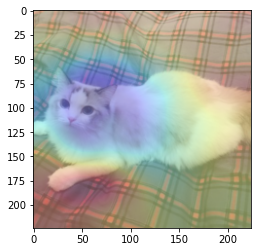

In [38]:
plt.imshow(mean_out, cmap='jet', alpha=0.5)
test_img = img.squeeze(0).permute(1, 2, 0).numpy()
plt.imshow((test_img - np.min(test_img)) / (np.max(test_img) - np.min(test_img)), alpha=0.5)

In [104]:
cnn = torchvision.models.vgg16(pretrained=True)

In [105]:
cnn

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1